* [Purpose] The proposed MW-GA-GRU model is compared with ARIMA, GARCH, ANN, SVR, RNN, LSTM, and GRU based on the data of copper price in Changjiang.

### Import related package.

In [1]:
## Data preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Visulization
import matplotlib.pyplot as plt

## ARIMA and SARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ndiffs
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm ##Automatically decide on ARIMA configuration
import statsmodels.api as sm

## The warning infomation dialog
import warnings
warnings.filterwarnings("ignore")

### Data preparedef read(path):

In [20]:
def read(path):
    return pd.read_csv(path)

In [21]:
len(data)

479

In [22]:
path = "WeeklyFinalData.csv"
data = read(path)
train = data["CCSP"][:int(len(data)*0.7)]
test = data["CCSP"][int(len(data)*0.7):]
data = data["CCSP"]

### Model the SARIMA model

In [23]:
model = sm.tsa.statespace.SARIMAX(train, order=(1,1,0), seasonal_order=(0,1,2,53))
model_fit = model.fit()
# model_fit.summary()

### Forecast

In [28]:
pre_sarima = model_fit.forecast(142)

In [29]:
pre_sarima.reset_index(drop=True, inplace=True)

In [30]:
performance_0["SARIMA"] = pre_sarima
performance_1["SARIMA"] = pre_sarima
performance_2["SARIMA"] = pre_sarima
performance_3["SARIMA"] = pre_sarima

In [31]:
performance_0

,Actual,SARIMA
0,50624.0,49173.313981
1,49362.0,49757.104562
2,50484.0,49013.765469
3,50818.0,48712.670773
4,51174.0,48758.481436
...,...,...
137,51620.0,56836.965929
138,52124.0,56743.435274
139,53216.0,56643.191860
140,54890.0,57005.002923


# Read and pre-process data

In [157]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Flatten, Input
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Metric

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.keras.backend.set_session(sess)

In [158]:
def read(path):
    return pd.read_csv(path)

In [159]:
def buildTrain(train, pastWeek=4, futureWeek=4, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
       
        X = np.array(train.iloc[i:i+defaultWeek])
        X = np.append(X,train["CCSP"].iloc[i+defaultWeek:i+pastWeek])
        
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    
    return np.array(X_train), np.array(Y_train)

In [160]:
def get_data():
    
    ## Read weekly copper price data
    path = "WeeklyFinalData.csv"
    data = read(path)
    
    date = data["Date"]
    data.drop("Date", axis=1, inplace=True)
    
    ## Add time lag (pastWeek=4, futureWeek=1)
    x_data, y_data = buildTrain(data)
    
    ## Data split
    x_train = x_data[:int(x_data.shape[0]*0.7)]
    x_test = x_data[int(x_data.shape[0]*0.7):]
    
    y_train = y_data[:int(x_data.shape[0]*0.7)]
    y_test = y_data[int(x_data.shape[0]*0.7):]
    
    return (x_train, x_test, y_train, y_test)

In [161]:
x_train, x_test, y_train, y_test = get_data()

In [162]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(329, 18)
(329, 4)
(142, 18)
(142, 4)


In [163]:
sc = MinMaxScaler(feature_range = (0, 1))

In [164]:
x_train, x_test, y_train, y_test = get_data()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)
y_train_scaled = sc.fit_transform(y_train)

In [101]:
# performance_0 = pd.DataFrame()
# performance_1 = pd.DataFrame()
# performance_2 = pd.DataFrame()
# performance_3 = pd.DataFrame()

In [19]:
# performance_0["Actual"] = y_test[:,0]
# performance_1["Actual"] = y_test[:,1]
# performance_2["Actual"] = y_test[:,2]
# performance_3["Actual"] = y_test[:,3]

# Modeling for SVR

In [40]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

In [41]:
svr_rbf = MultiOutputRegressor(SVR(kernel = 'rbf', C=1e3 , gamma = 0.1))
svr_rbf.fit(x_train_scaled, y_train_scaled)

MultiOutputRegressor(estimator=SVR(C=1000.0, gamma=0.1))

In [42]:
SVR_predict = svr_rbf.predict(x_test_scaled)

In [43]:
pre_svm = sc.inverse_transform(SVR_predict)

In [44]:
performance_0["SVR"] = pre_svm[:,0]
performance_1["SVR"] = pre_svm[:,1]
performance_2["SVR"] = pre_svm[:,2]
performance_3["SVR"] = pre_svm[:,3]

# 3. Modeling for ANN

### Build 2-layer neural network

In [211]:
def buildTwoLayerNN(input_shape):

    keras.backend.clear_session()
    model = Sequential()
    model.add(Dense(units=36, activation ="relu", input_shape=(input_shape,)))
    model.add(Dense(units=4)) 

    model.compile(optimizer="Adam", loss="mean_squared_error")

    return model

In [212]:
input_shape = x_train_scaled.shape[1]
model = buildTwoLayerNN(input_shape)

In [223]:
model.fit(x_train_scaled, y_train_scaled, epochs=20, verbose=0)

### Forecast

In [224]:
# model.save("ann_model_weight.h5")
ANN_predict = model.predict(x_test_scaled)

In [225]:
pre_ann = sc.inverse_transform(ANN_predict)

In [226]:
performance_0["ANN"] = pre_ann[:,0]
performance_1["ANN"] = pre_ann[:,1]
performance_2["ANN"] = pre_ann[:,2]
performance_3["ANN"] = pre_ann[:,3]

In [227]:
performance_0

,Actual,SARIMA,SVR,ANN,RNN,LSTM,GRU
0,50624.0,49173.313981,53243.379531,51286.355469,53679.746094,51878.324219,51442.929688
1,49362.0,49757.104562,52253.731306,50618.726562,53826.546875,51217.593750,50690.238281
2,50484.0,49013.765469,50612.641512,49680.132812,53278.519531,50406.074219,49749.562500
3,50818.0,48712.670773,50754.607122,49047.257812,53766.902344,50727.839844,50084.062500
4,51174.0,48758.481436,51337.173084,49573.382812,53602.375000,51711.613281,51689.632812
...,...,...,...,...,...,...,...
137,51620.0,56836.965929,44273.439308,47449.468750,45028.417969,40838.457031,42524.746094
138,52124.0,56743.435274,44396.248815,47794.074219,45967.125000,40927.082031,42863.691406
139,53216.0,56643.191860,44479.969989,47509.089844,45125.644531,40800.019531,43067.898438
140,54890.0,57005.002923,45191.205667,48234.886719,46756.628906,41325.644531,44245.824219


# Prepare the corresponding data for RNN-based NN

In [126]:
def buildTrain(train, pastWeek, futureWeek=4, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
        
        X = np.array(train.iloc[i:i+pastWeek,:])
        
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    return (np.array(X_train), np.array(Y_train))

In [127]:
def get_data(timeLag):
    
    ## Read weekly copper price data
    path = "WeeklyFinalData.csv"
    data = read(path)
    
    date = data["Date"]
    data.drop("Date", axis=1, inplace=True)
    
    ## Add time lag (pastWeek=4, futureWeek=1)
    x_data, y_data = buildTrain(data, timeLag)
    
    ## Data split
    x_train = x_data[0:int(x_data.shape[0]*0.7)]
    x_test = x_data[int(x_data.shape[0]*0.7):]
    
    y_train = y_data[0:int(x_data.shape[0]*0.7)]
    y_test = y_data[int(x_data.shape[0]*0.7):]
    
    
    return (x_train, x_test, y_train, y_test)

In [128]:
x_train, x_test, y_train, y_test = get_data(4)
## The number of forecasting variable (# of variable)
nb_input_factor = 15

## Data transformation
x_train_scaled = sc.fit_transform(x_train).reshape(-1,4,nb_input_factor)
x_test_scaled = sc.transform(x_test).reshape(-1,4,nb_input_factor)
y_train_scaled = sc.fit_transform(y_train)

# 4. Modeling for RNN

In [129]:
import tensorflow as tf
from tensorflow import keras

In [130]:
from keras.layers import SimpleRNN

In [131]:
def buildRNN(shape):
    
    keras.backend.clear_session()
    model = keras.Sequential()
    model.add(SimpleRNN(36, input_shape=(shape[1], shape[2])))
    model.add(Dense(4))
    model.compile(optimizer="Adam", loss="mse")
#     model.summary()
    return model

In [132]:
model = buildRNN(x_train_scaled.shape)
model.fit(x_train_scaled, y_train_scaled, epochs=100, batch_size=30, verbose=0)

In [133]:
RNN_predict = model.predict(x_test_scaled)

In [134]:
pre_rnn = sc.inverse_transform(RNN_predict)

In [135]:
performance_0["RNN"] = pre_rnn[:,0]
performance_1["RNN"] = pre_rnn[:,1]
performance_2["RNN"] = pre_rnn[:,2]
performance_3["RNN"] = pre_rnn[:,3]

In [136]:
performance_0

,Actual,SARIMA,SVR,ANN,RNN,LSTM,GRU
0,50624.0,49173.313981,53243.379531,51979.992188,53679.746094,50622.996094,51517.972656
1,49362.0,49757.104562,52253.731306,51418.113281,53826.546875,50016.527344,50651.429688
2,50484.0,49013.765469,50612.641512,50422.507812,53278.519531,49606.351562,50031.675781
3,50818.0,48712.670773,50754.607122,50500.281250,53766.902344,50247.792969,50969.875000
4,51174.0,48758.481436,51337.173084,50231.234375,53602.375000,50744.410156,51656.125000
...,...,...,...,...,...,...,...
137,51620.0,56836.965929,44273.439308,43246.863281,45028.417969,37194.503906,45960.214844
138,52124.0,56743.435274,44396.248815,42409.480469,45967.125000,37073.472656,46565.882812
139,53216.0,56643.191860,44479.969989,43402.546875,45125.644531,37528.925781,46450.593750
140,54890.0,57005.002923,45191.205667,43321.058594,46756.628906,38550.039062,47918.703125


# 5. Modeling for LSTM

In [142]:
from keras.layers import LSTM

In [143]:
def buildLSTM(shape):
    
    model = Sequential()
    model.add(LSTM(36, input_shape=(shape[1], shape[2])))
    model.add(Dense(4))
    model.compile(optimizer="Adam", loss="mse")
#     model.summary()
    return model

In [144]:
model = buildLSTM(x_train_scaled.shape)
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=30, verbose=0)

In [145]:
LSTM_predict = model.predict(x_test_scaled)

In [146]:
pre_lstm = sc.inverse_transform(LSTM_predict)

In [147]:
performance_0["LSTM"] = pre_lstm[:,0]
performance_1["LSTM"] = pre_lstm[:,1]
performance_2["LSTM"] = pre_lstm[:,2]
performance_3["LSTM"] = pre_lstm[:,3]

# 6. Modeling for GRU

In [148]:
from keras.layers import GRU

In [149]:
def buildGRU(shape):
    
    model = Sequential()
    model.add(GRU(36, input_shape=(shape[1], shape[2])))
    model.add(Dense(4))
    model.compile(optimizer="Adam", loss="mse")
#     model.summary()
    return model

In [150]:
model = buildGRU(x_train_scaled.shape)
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=30, verbose=0)
GRU_predict = model.predict(x_test_scaled)

In [151]:
pre_gru = sc.inverse_transform(GRU_predict)

In [152]:
performance_0["GRU"] = pre_gru[:,0]
performance_1["GRU"] = pre_gru[:,1]
performance_2["GRU"] = pre_gru[:,2]
performance_3["GRU"] = pre_gru[:,3]

In [153]:
# performance.drop(["Actual"],1,inplace=True)

In [391]:
# performance_0.insert(0,"Actual", y_test[:,0])
# performance_1.insert(0,"Actual", y_test[:,1])
# performance_2.insert(0,"Actual", y_test[:,2])
# performance_3.insert(0,"Actual", y_test[:,3])

In [583]:
pre_LDSS = read("pre_LDSS.csv")

In [584]:
performance_0.insert(1,"Proposed LDSS",pre_LDSS["0"])

ValueError: cannot insert Proposed LDSS, already exists

In [585]:
performance_1.insert(1,"Proposed LDSS",pre_LDSS["1"])
performance_2.insert(1,"Proposed LDSS",pre_LDSS["2"])
performance_3.insert(1,"Proposed LDSS",pre_LDSS["3"])

ValueError: cannot insert Proposed LDSS, already exists

In [228]:
performances = [performance_0, performance_1, performance_2, performance_3]

In [396]:
performance_0 = performance_0[:-1]
performance_1 = performance_1[:-1]
performance_2 = performance_2[:-1]
performance_3 = performance_3[:-1]

In [587]:
performance_0

,Actual,Proposed LDSS,SARIMA,SVR,ANN,RNN,LSTM,GRU
0,51340.0,50583.59219,53745.362502,51329.529416,51177.121094,51411.472656,51704.656250,51433.132812
1,51242.0,50305.53683,53588.703726,51706.948741,50804.945312,51492.449219,52072.804688,51675.566406
2,52704.0,49860.52592,54303.571917,51852.336062,50620.523438,51904.734375,52317.660156,51518.320312
3,53422.0,50377.48312,54474.997793,52287.921531,50757.269531,52563.332031,53602.386719,53225.015625
4,52008.0,51009.05831,54475.827337,52593.157775,51360.433594,53005.777344,53771.195312,53061.890625
...,...,...,...,...,...,...,...,...
127,51726.0,45241.03864,69408.965659,45171.064384,44171.835938,41942.011719,43754.765625,42458.929688
128,51620.0,44875.37559,69319.643691,44402.750091,44152.820312,42886.433594,43958.164062,41864.597656
129,52124.0,44716.92105,69680.518345,44481.855047,44286.136719,41742.601562,44405.207031,42465.929688
130,53216.0,44948.48751,69330.560614,44549.510973,44996.050781,41492.855469,45039.597656,42236.023438


# Plot a graph comparing the predicted value with the actual value.

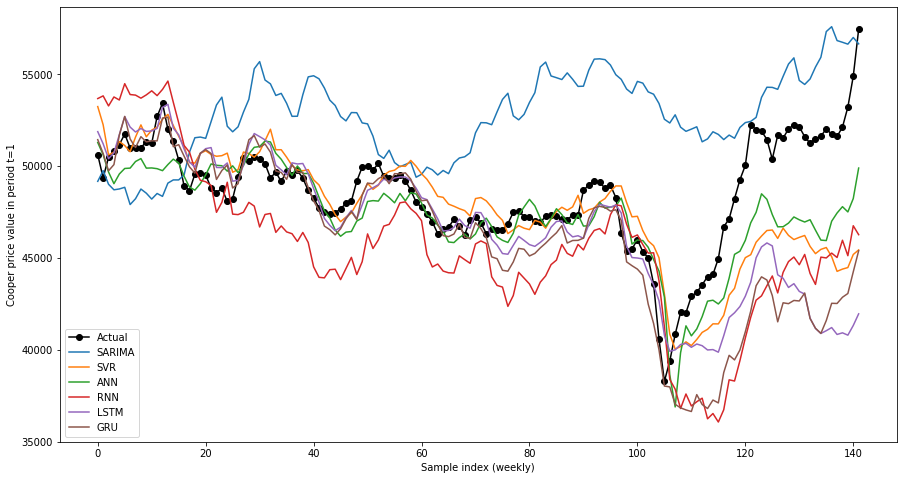

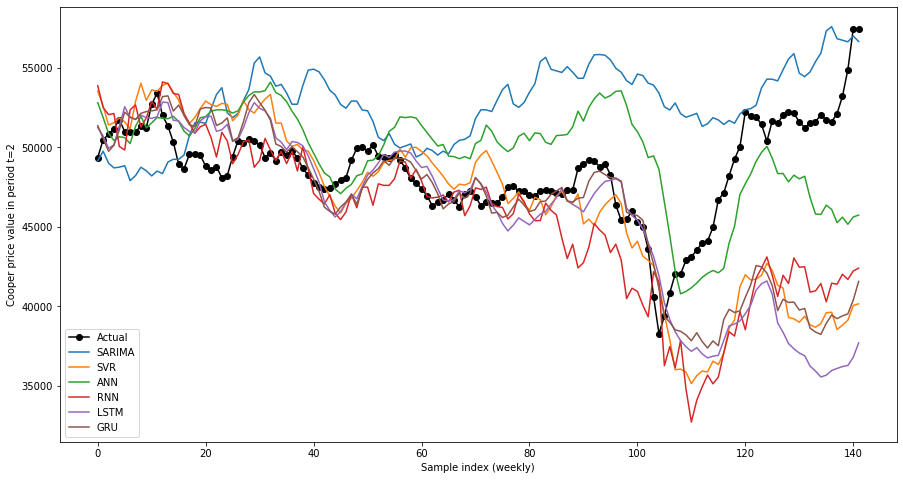

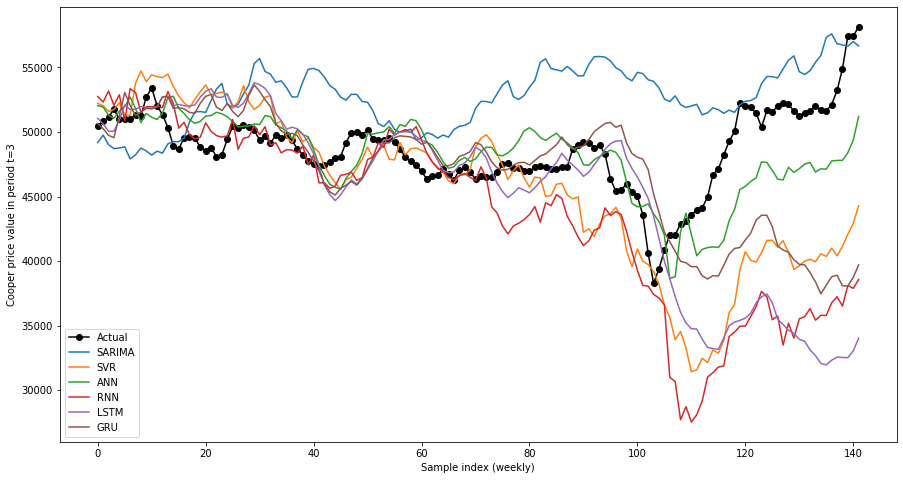

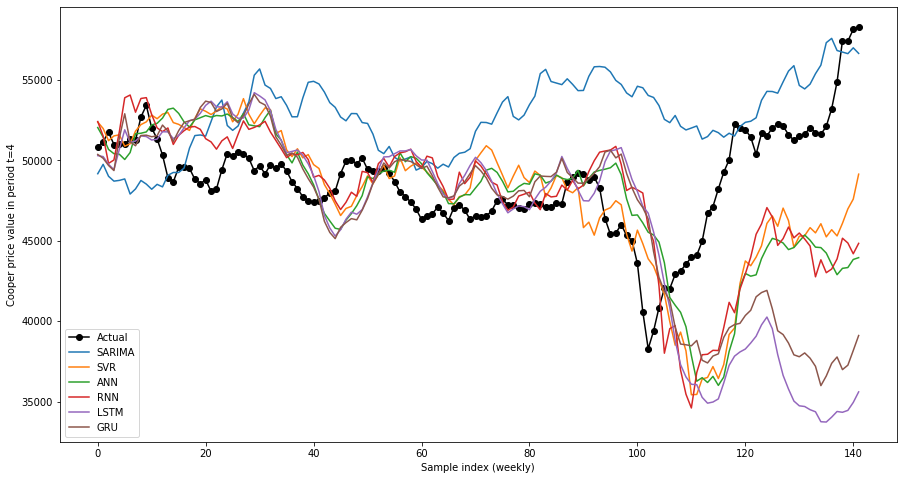

In [229]:
l=1
for performance in performances:
    
    plt.figure(figsize=(15,8))

    plt.plot(range(performance["Actual"].shape[0]), performance["Actual"], "-o",color='black', label = 'Actual')

    for i in range(1,performance.shape[1]):
        t_data = performance.iloc[:,i]
        plt.plot(t_data, label=performance.columns[i])

    plt.legend()
    plt.xlabel("Sample index (weekly)")
    plt.ylabel("Cooper price value in period t=%d"%(l))
    plt.savefig('RMSE_%d.png'%(l),dpi=500)
    l+=1

# Create the function to evaluate the performance of each model based on the RMSE, MAE, MAPE, and the accuracy from 500 to 3000 tolerance.

In [230]:
# evaluation_results = pd.DataFrame(columns=["Model","MAE","MAPE","RMSE"])

mae = tf.keras.losses.MeanAbsoluteError()
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()
l=1
for performance in performances:

    evaluation_results = pd.DataFrame(columns=["Model","MAE","MAPE","RMSE"])
    
    for i in range(1,performance.shape[1]):
         
        val_mae = mae(performance["Actual"], performance.iloc[:,i]).numpy()
        val_mae = np.round(val_mae,2)
        val_mape = mape(performance["Actual"], performance.iloc[:,i]).numpy()
        val_rmse = tf.math.sqrt(mse(performance["Actual"], performance.iloc[:,i])).numpy()
        accuracy = list()

        for threshold in range(500,3001,500):

            y_true = performance["Actual"]
            y_pred = performance.iloc[:,i]

            total_times = y_true.shape[0]
            correct_times = 0

            for _ in range(total_times): 

                correct_times = np.count_nonzero(abs(y_true-y_pred) < threshold)

            accuracy.append(correct_times/total_times)


        new_result = pd.DataFrame({

            "Model" : [performance.columns[i]],
            "MAE" : [val_mae],
            "MAPE" : [val_mape],
            "RMSE" : [val_rmse],
#             "Accuracy(500)" : accuracy[0]*100,
#             "Accuracy(1000)" : accuracy[1]*100,
#             "Accuracy(1500)" : accuracy[2]*100,
            "Accuracy(2000)" : str(round(accuracy[3]*100,2))+"%",
#             "Accuracy(2500)" : accuracy[4]*100,
            "Accuracy(3000)" : str(round(accuracy[5]*100,2))+"%"

        })

        evaluation_results = evaluation_results.append(new_result, ignore_index=True)
    print(evaluation_results)
    evaluation_results.to_csv("result_%d.csv"%(l), index=False)
    l+=1

    Model          MAE       MAPE         RMSE Accuracy(2000) Accuracy(3000)
0  SARIMA  4718.380000  10.041846  5482.864945         14.79%         32.39%
1     SVR  2111.300000   4.282862  3077.158917         69.72%         79.58%
2     ANN  1726.180054   3.498274  2399.279053         73.24%         78.87%
3     RNN  3663.270020   7.491592  4492.775879         24.65%         54.23%
4    LSTM  2480.820068   4.956949  4124.972168         71.13%         78.87%
5     GRU  2789.219971   5.658113  4408.396973         69.01%         75.35%
    Model          MAE      MAPE         RMSE Accuracy(2000) Accuracy(3000)
0  SARIMA  4651.440000  9.915573  5482.920025          16.2%         34.51%
1     SVR  3990.540000  8.044112  5845.739987         46.48%         63.38%
2     ANN  3295.739990  6.836233  3952.071777         27.46%         45.77%
3     RNN  3889.879883  7.909442  5571.562988         48.59%         59.15%
4    LSTM  3961.429932  7.905646  6474.215332         57.04%         70.42%
5    

In [557]:
performance_0.to_csv("performance_0.csv", index=False)
performance_1.to_csv("performance_1.csv", index=False)
performance_2.to_csv("performance_2.csv", index=False)
performance_3.to_csv("performance_3.csv", index=False)